# Qiskit Algorithms: Simple Examples

This notebook demonstrates several fundamental quantum algorithms implemented using Qiskit. Each algorithm is explained with its theoretical background, implementation details, and visualization of results.

## Table of Contents
1. [Introduction to Qiskit](#introduction)
2. [Deutsch-Jozsa Algorithm](#deutsch-jozsa)
3. [Bernstein-Vazirani Algorithm](#bernstein-vazirani)
4. [Quantum Teleportation](#quantum-teleportation)
5. [Quantum Fourier Transform](#qft)
6. [Phase Estimation](#phase-estimation)
7. [SWAP Test](#swap-test)

<a id="introduction"></a>
## 1. Introduction to Qiskit

Qiskit is an open-source SDK for working with quantum computers at the level of pulses, circuits, and application modules. In this notebook, we'll use Qiskit to implement several fundamental quantum algorithms.

In [40]:
# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Import NumPy for numerical operations
import numpy as np

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

<a id="deutsch-jozsa"></a>
## 2. Deutsch-Jozsa Algorithm

The Deutsch-Jozsa algorithm was one of the first quantum algorithms to demonstrate a speedup over classical algorithms. It solves a specific problem: determining whether a function is constant or balanced.

### Problem Statement:
- Given a black-box function f(x) that takes an n-bit input and returns either 0 or 1
- The function is promised to be either:
  - **Constant**: Returns the same output (either all 0s or all 1s) for all inputs
  - **Balanced**: Returns 0 for exactly half of all possible inputs, and 1 for the other half
- Goal: Determine whether f(x) is constant or balanced

### Classical Solution:
- Worst case: Need to check 2^(n-1) + 1 inputs to be certain
- For large n, this becomes exponentially complex

### Quantum Solution:
- The Deutsch-Jozsa algorithm can solve this with just one function evaluation
- This provides an exponential speedup over the classical approach

In [42]:
def deutsch_jozsa_algorithm(oracle_type='constant', oracle_value=0):
    """
    Implement the Deutsch-Jozsa algorithm.
    
    Args:
        oracle_type (str): 'constant' or 'balanced'
        oracle_value (int): For constant oracle, the constant value (0 or 1)
                           For balanced oracle, this is ignored
    
    Returns:
        QuantumCircuit: The complete Deutsch-Jozsa circuit
    """
    # Create a circuit with n+1 qubits (n input qubits + 1 output qubit)
    # For simplicity, we'll use n=2 (2 input qubits)
    n = 2
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Initialize output qubit in state |1⟩
    dj_circuit.x(n)
    
    # Apply Hadamard gates to all qubits
    for qubit in range(n+1):
        dj_circuit.h(qubit)
    
    dj_circuit.barrier()  # For visual separation
    
    # Apply the oracle
    if oracle_type == 'constant':
        # Constant oracle
        if oracle_value == 1:
            # If f(x) = 1 for all x, apply X to the output qubit
            dj_circuit.x(n)
    else:  # balanced
        # For a balanced function, we'll use a simple implementation
        # This particular implementation returns f(x) = x_0 ⊕ x_1
        dj_circuit.cx(0, n)
        dj_circuit.cx(1, n)
    
    dj_circuit.barrier()
    
    # Apply Hadamard gates to the input qubits
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    # Measure the input qubits
    for qubit in range(n):
        dj_circuit.measure(qubit, qubit)
    
    return dj_circuit

Circuit for constant function f(x) = 0:


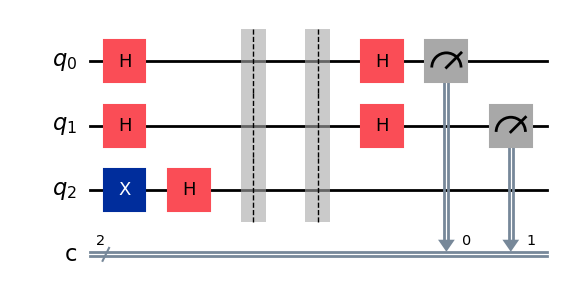

Circuit for balanced function f(x) = x_0 ⊕ x_1:


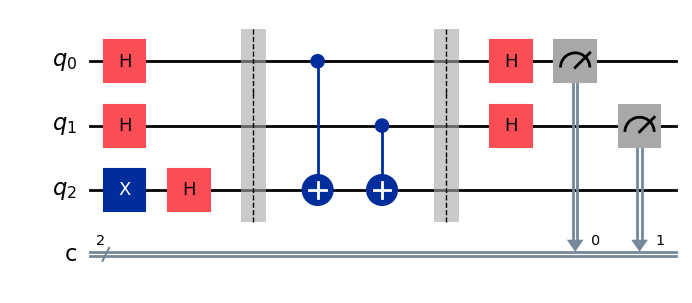

In [43]:
# Create and run a circuit with a constant oracle
constant_circuit = deutsch_jozsa_algorithm('constant', 0)
print("Circuit for constant function f(x) = 0:")
display(constant_circuit.draw(output='mpl'))

# Create and run a circuit with a balanced oracle
balanced_circuit = deutsch_jozsa_algorithm('balanced')
print("Circuit for balanced function f(x) = x_0 ⊕ x_1:")
display(balanced_circuit.draw(output='mpl'))

Results for constant function:


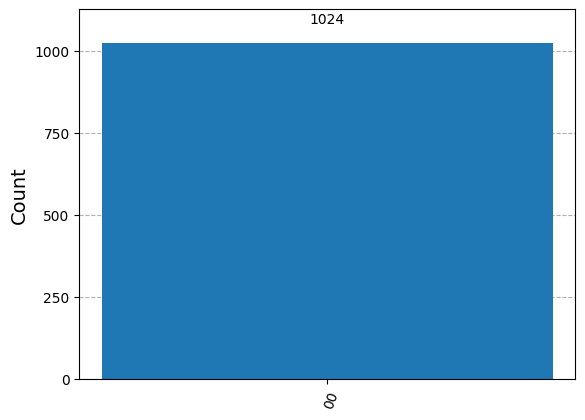

Results for balanced function:


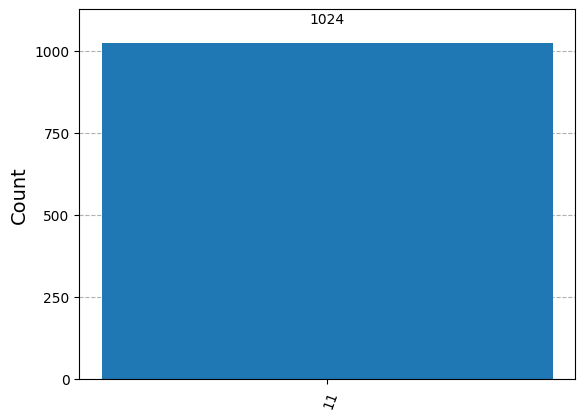

In [44]:
# Simulate the constant circuit
simulator = BasicSimulator()
result_constant = simulator.run(constant_circuit).result()
counts_constant = result_constant.get_counts()
print("Results for constant function:")
display(plot_histogram(counts_constant))

# Simulate the balanced circuit
result_balanced = simulator.run(balanced_circuit).result()
counts_balanced = result_balanced.get_counts()
print("Results for balanced function:")
display(plot_histogram(counts_balanced))

### Interpretation:
- If the function is constant, all input qubits will be measured as |0⟩
- If the function is balanced, at least one input qubit will be measured as |1⟩
- This allows us to determine with certainty whether the function is constant or balanced with just one query to the function

<a id="bernstein-vazirani"></a>
## 3. Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm is designed to find a hidden bit string. It demonstrates a quantum speedup over classical algorithms for a specific problem.

### Problem Statement:
- Given a black-box function f(x) = s·x (mod 2) where:
  - s is a hidden n-bit string
  - x is an n-bit input string
  - s·x is the bitwise dot product: s·x = (s₀·x₀) ⊕ (s₁·x₁) ⊕ ... ⊕ (sₙ₋₁·xₙ₋₁)
- Goal: Find the hidden string s

### Classical Solution:
- Need to query the function n times (once for each bit of s)
- Time complexity: O(n)

### Quantum Solution:
- The Bernstein-Vazirani algorithm can find s with just one query
- Time complexity: O(1) in terms of function evaluations

In [45]:
def bernstein_vazirani_algorithm(hidden_string):
    """
    Implement the Bernstein-Vazirani algorithm.
    
    Args:
        hidden_string (str): The hidden binary string s
    
    Returns:
        QuantumCircuit: The complete Bernstein-Vazirani circuit
    """
    # Convert the hidden string to a list of integers
    s = [int(bit) for bit in hidden_string]
    n = len(s)
    
    # Create a circuit with n+1 qubits (n input qubits + 1 output qubit)
    bv_circuit = QuantumCircuit(n+1, n)
    
    # Initialize output qubit in state |1⟩
    bv_circuit.x(n)
    
    # Apply Hadamard gates to all qubits
    for qubit in range(n+1):
        bv_circuit.h(qubit)
    
    bv_circuit.barrier()
    
    # Apply the oracle (controlled-Z gates for each bit in s that is 1)
    for qubit in range(n):
        if s[qubit] == 1:
            bv_circuit.cz(qubit, n)
    
    bv_circuit.barrier()
    
    # Apply Hadamard gates to the input qubits
    for qubit in range(n):
        bv_circuit.h(qubit)
    
    # Measure the input qubits
    for qubit in range(n):
        bv_circuit.measure(qubit, qubit)
    
    return bv_circuit

Circuit for hidden string s = 101:


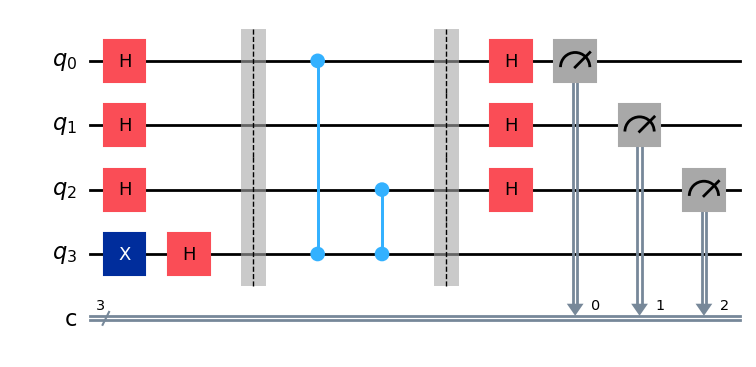

Results (should match the hidden string):


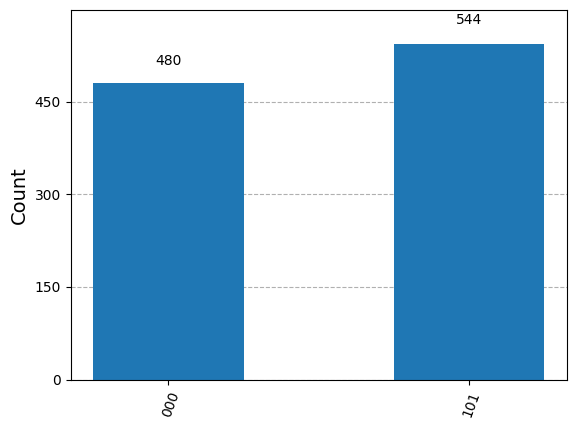

In [46]:
# Define a hidden string
hidden_string = "101"  # Example: s = 101

# Create the Bernstein-Vazirani circuit
bv_circuit = bernstein_vazirani_algorithm(hidden_string)
print(f"Circuit for hidden string s = {hidden_string}:")
display(bv_circuit.draw(output='mpl'))

# Simulate the circuit
simulator = BasicSimulator()
result = simulator.run(bv_circuit).result()
counts = result.get_counts()
print("Results (should match the hidden string):")
display(plot_histogram(counts))

### Interpretation:
- The measurement result directly gives us the hidden string s
- This demonstrates a quantum advantage, as we only needed one query to the function instead of n queries classically

<a id="quantum-teleportation"></a>
## 4. Quantum Teleportation

Quantum teleportation is a protocol that transfers a quantum state from one location to another, using a previously shared entangled state and classical communication.

### Protocol Overview:
1. Alice and Bob share an entangled pair of qubits (Bell state)
2. Alice has a qubit in some state |ψ⟩ that she wants to teleport to Bob
3. Alice performs a Bell measurement on her qubit and her half of the entangled pair
4. Alice sends the classical measurement results to Bob
5. Based on these results, Bob applies appropriate gates to his qubit
6. Bob's qubit is now in the state |ψ⟩

In [47]:
def quantum_teleportation(initial_state=[1/np.sqrt(2), 1/np.sqrt(2)]):
    """
    Implement the quantum teleportation protocol.
    
    Args:
        initial_state (list): The state to teleport [alpha, beta] where |ψ⟩ = alpha|0⟩ + beta|1⟩
    
    Returns:
        QuantumCircuit: The complete quantum teleportation circuit
    """
    # Create a circuit with 3 qubits and 2 classical bits
    # q0: Alice's qubit to teleport
    # q1: Alice's half of the entangled pair
    # q2: Bob's half of the entangled pair
    teleport_circuit = QuantumCircuit(3, 2)
    
    # Prepare the state to teleport on q0
    teleport_circuit.initialize(initial_state, 0)
    
    # Create Bell pair between q1 and q2
    teleport_circuit.h(1)
    teleport_circuit.cx(1, 2)
    
    teleport_circuit.barrier()
    
    # Alice's Bell measurement
    teleport_circuit.cx(0, 1)
    teleport_circuit.h(0)
    teleport_circuit.measure([0, 1], [0, 1])
    
    teleport_circuit.barrier()
    
    # Bob's corrections based on Alice's measurements
    # If Alice measured |00⟩, Bob does nothing (identity operation)
    # If Alice measured |01⟩, Bob applies X
    teleport_circuit.x(2).c_if(0, 1)
    # If Alice measured |10⟩, Bob applies Z
    teleport_circuit.z(2).c_if(1, 1)
    # If Alice measured |11⟩, Bob applies ZX
    # This is implemented as X followed by Z when both conditions are met
    
    return teleport_circuit

Quantum Teleportation Circuit:


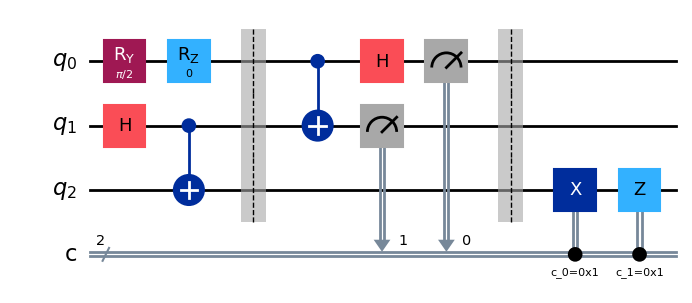

In [76]:
# Define a state to teleport
state_to_teleport = [1/np.sqrt(2), 1/np.sqrt(2)]  # |+⟩ state

# Replace the initialize operation with equivalent gate operations
def prepare_state(circuit, qubit, state):
	"""
	Prepare a quantum state on the specified qubit using gate operations.
	
	Args:
		circuit (QuantumCircuit): The quantum circuit
		qubit (int): The qubit index
		state (list): The state to prepare [alpha, beta]
	"""
	alpha, beta = state
	theta = 2 * np.arccos(alpha)
	phi = np.angle(beta)
	circuit.ry(theta, qubit)
	circuit.rz(phi, qubit)

# Create the teleportation circuit
teleport_circuit = QuantumCircuit(3, 2)
prepare_state(teleport_circuit, 0, state_to_teleport)

# Add the rest of the teleportation logic
teleport_circuit.h(1)
teleport_circuit.cx(1, 2)
teleport_circuit.barrier()
teleport_circuit.cx(0, 1)
teleport_circuit.h(0)
teleport_circuit.measure([0, 1], [0, 1])
teleport_circuit.barrier()
teleport_circuit.x(2).c_if(0, 1)
teleport_circuit.z(2).c_if(1, 1)

print("Quantum Teleportation Circuit:")
display(teleport_circuit.draw(output='mpl'))

# Simulate the circuit and visualize the final state
simulator = BasicSimulator()
result = simulator.run(teleport_circuit).result()

Final state (before measurement):


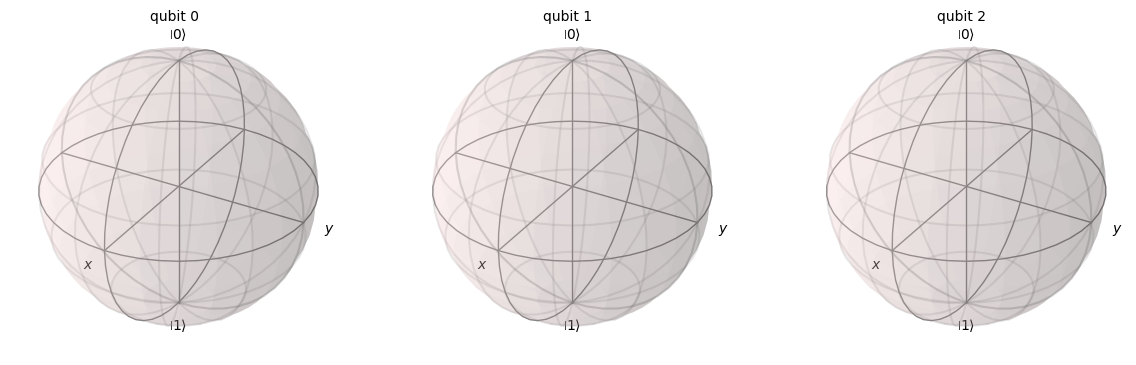

In [77]:
# To verify teleportation, we need to check Bob's qubit state
# We'll create a simplified circuit without measurements to check the state
verification_circuit = QuantumCircuit(3)
verification_circuit.initialize(state_to_teleport, 0)
verification_circuit.h(1)
verification_circuit.cx(1, 2)
verification_circuit.cx(0, 1)
verification_circuit.h(0)

# Get the statevector
state = Statevector(verification_circuit)
print("Final state (before measurement):")
display(plot_bloch_multivector(state))

### Interpretation:
- The protocol successfully transfers the quantum state from Alice to Bob
- This is not faster-than-light communication, as classical information must be transmitted
- The original qubit is not copied (which would violate the no-cloning theorem), but its state is transferred

<a id="qft"></a>
## 5. Quantum Fourier Transform

The Quantum Fourier Transform (QFT) is a quantum analog of the classical Discrete Fourier Transform. It's a fundamental building block for many quantum algorithms, including Shor's algorithm for factoring large numbers.

### Mathematical Definition:
The QFT transforms a quantum state |x⟩ into a superposition of states:

$$|x\rangle \mapsto \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i xy/N} |y\rangle$$

where N = 2^n for an n-qubit system.

In [78]:
def qft_circuit(n):
    """
    Create a Quantum Fourier Transform circuit for n qubits.
    
    Args:
        n (int): Number of qubits
    
    Returns:
        QuantumCircuit: The QFT circuit
    """
    qft = QuantumCircuit(n)
    
    # Apply QFT
    for i in range(n):
        qft.h(i)
        for j in range(i+1, n):
            # Controlled phase rotation
            qft.cp(2*np.pi/2**(j-i+1), j, i)
    
    # Swap qubits to match the standard QFT output order
    for i in range(n//2):
        qft.swap(i, n-i-1)
    
    return qft

3-qubit Quantum Fourier Transform Circuit:


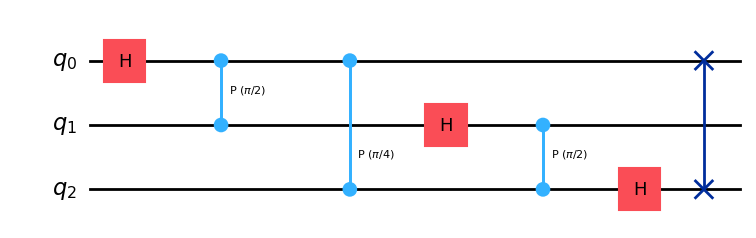

State after QFT:
Statevector([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j,
              0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j,
             -0.35355339+0.j, -0.35355339+0.j],
            dims=(2, 2, 2))


In [79]:
# Create a 3-qubit QFT circuit
n_qubits = 3
qft = qft_circuit(n_qubits)
print(f"{n_qubits}-qubit Quantum Fourier Transform Circuit:")
display(qft.draw(output='mpl'))

# Let's apply QFT to a specific state, e.g., |001⟩
input_circuit = QuantumCircuit(n_qubits)
input_circuit.x(0)  # Prepare |001⟩ state

# Combine the input preparation with QFT
complete_circuit = input_circuit.compose(qft)

# Simulate and visualize the state after QFT
state = Statevector(complete_circuit)
print("State after QFT:")
print(state)

### Applications of QFT:
- Shor's algorithm for integer factorization
- Quantum phase estimation
- Quantum counting
- Hidden subgroup problems

<a id="phase-estimation"></a>
## 6. Phase Estimation

Quantum Phase Estimation (QPE) is a quantum algorithm used to estimate the eigenvalue of a unitary operator. It's a key component in many quantum algorithms, including Shor's algorithm.

### Problem Statement:
- Given a unitary operator U and an eigenstate |ψ⟩ such that U|ψ⟩ = e^(2πiθ)|ψ⟩
- Goal: Estimate the phase θ with high precision

In [53]:
def phase_estimation_circuit(unitary, precision):
    """
    Create a Quantum Phase Estimation circuit.
    
    Args:
        unitary: The unitary operator (in this example, a phase gate)
        precision (int): Number of bits of precision (number of counting qubits)
    
    Returns:
        QuantumCircuit: The QPE circuit
    """
    # Create a circuit with precision+1 qubits
    # precision qubits for counting, 1 qubit for the eigenstate
    qpe = QuantumCircuit(precision+1, precision)
    
    # Initialize the eigenstate
    qpe.x(precision)  # Prepare |1⟩ as the eigenstate
    
    # Apply Hadamard gates to counting qubits
    for qubit in range(precision):
        qpe.h(qubit)
    
    qpe.barrier()
    
    # Apply controlled unitary operations
    # For each counting qubit, apply the controlled-U operation 2^j times
    for j in range(precision):
        # Apply controlled-U^(2^j) operation
        for _ in range(2**j):
            qpe.cp(unitary, j, precision)
    
    qpe.barrier()
    
    # Apply inverse QFT to the counting qubits
    # First, apply Hadamard gates
    for j in range(precision):
        qpe.h(j)
        # Apply controlled phase rotations
        for k in range(j):
            qpe.cp(-np.pi/float(2**(j-k)), k, j)
        qpe.h(j)
    
    # Swap qubits to match the standard QFT output order
    for j in range(precision//2):
        qpe.swap(j, precision-j-1)
    
    # Measure the counting qubits
    qpe.measure(range(precision), range(precision))
    
    return qpe

Quantum Phase Estimation Circuit (estimating phase θ = 0.25):


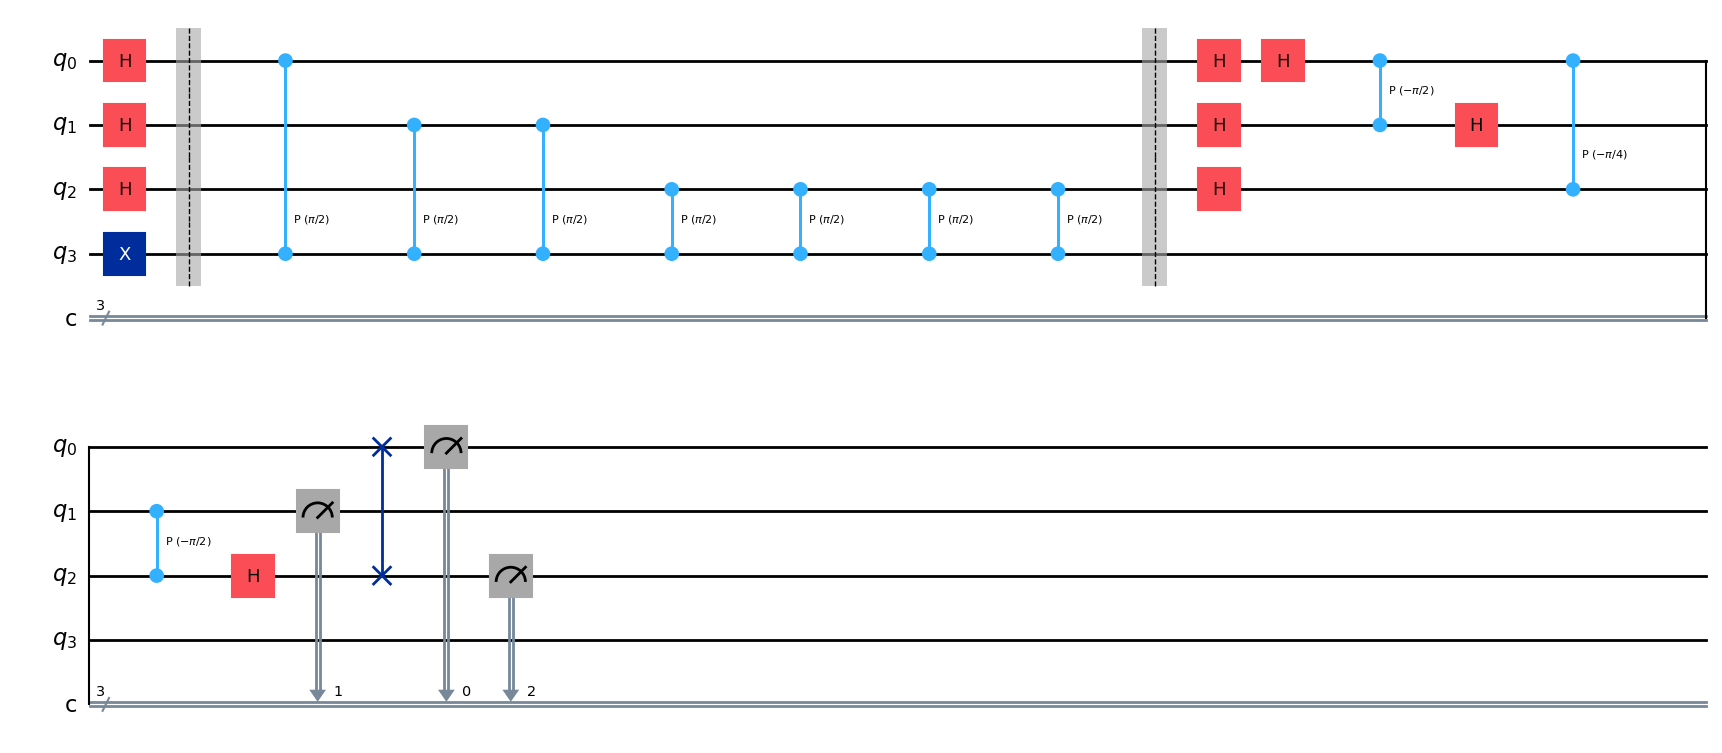

Measurement results:


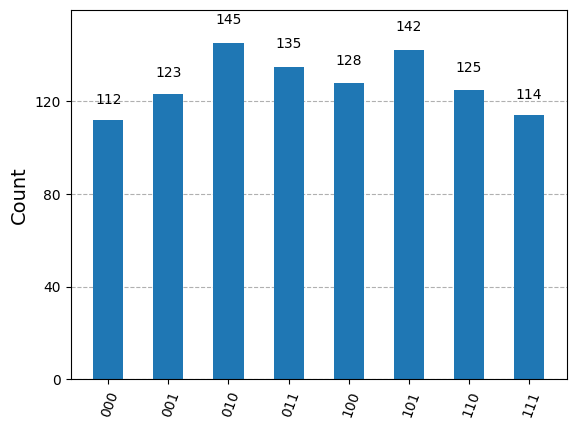

Estimated phase: 0.25
True phase: 0.25
Error: 0.0


In [54]:
# Define a phase to estimate
true_phase = 0.25  # θ = 1/4
unitary_phase = 2 * np.pi * true_phase  # Phase angle in radians

# Create a 4-qubit QPE circuit (3 counting qubits + 1 eigenstate qubit)
precision = 3
qpe_circuit = phase_estimation_circuit(unitary_phase, precision)
print(f"Quantum Phase Estimation Circuit (estimating phase θ = {true_phase}):")
display(qpe_circuit.draw(output='mpl'))

# Simulate the circuit
simulator = BasicSimulator()
result = simulator.run(qpe_circuit, shots=1024).result()
counts = result.get_counts()
print("Measurement results:")
display(plot_histogram(counts))

# Convert the most common result to a phase estimate
most_common_result = max(counts, key=counts.get)
phase_estimate = int(most_common_result, 2) / (2**precision)
print(f"Estimated phase: {phase_estimate}")
print(f"True phase: {true_phase}")
print(f"Error: {abs(phase_estimate - true_phase)}")

### Applications:
- Eigenvalue estimation
- Shor's algorithm
- Quantum counting
- Quantum chemistry simulations

<a id="swap-test"></a>
## 7. SWAP Test

The SWAP test is a quantum algorithm used to measure the similarity between two quantum states. It calculates the absolute value of the inner product between two states.

### Problem Statement:
- Given two quantum states |ψ⟩ and |φ⟩
- Goal: Estimate |⟨ψ|φ⟩|², which measures how similar the states are

In [55]:
def swap_test_circuit(state1, state2):
    """
    Create a SWAP test circuit to measure similarity between two quantum states.
    
    Args:
        state1 (list): First quantum state [alpha, beta]
        state2 (list): Second quantum state [gamma, delta]
    
    Returns:
        QuantumCircuit: The SWAP test circuit
    """
    # Create a circuit with 3 qubits and 1 classical bit
    # q0: Ancilla qubit
    # q1: First state
    # q2: Second state
    swap_circuit = QuantumCircuit(3, 1)
    
    # Initialize the states
    swap_circuit.initialize(state1, 1)
    swap_circuit.initialize(state2, 2)
    
    # Apply Hadamard to the ancilla qubit
    swap_circuit.h(0)
    
    swap_circuit.barrier()
    
    # Apply controlled-SWAP (Fredkin gate)
    swap_circuit.cswap(0, 1, 2)
    
    swap_circuit.barrier()
    
    # Apply Hadamard to the ancilla qubit again
    swap_circuit.h(0)
    
    # Measure the ancilla qubit
    swap_circuit.measure(0, 0)
    
    return swap_circuit

SWAP Test Circuit:


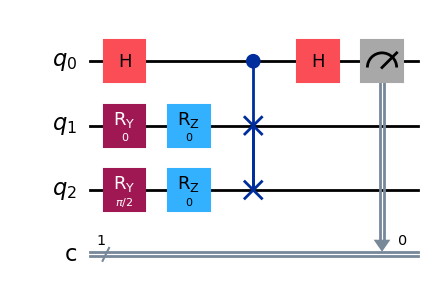

Measurement results:


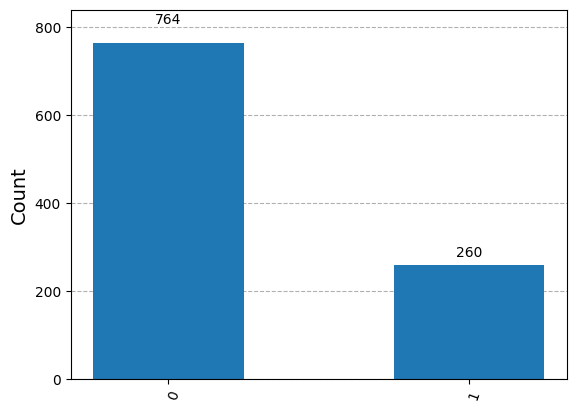

Probability of measuring |0⟩: 0.7461
Estimated overlap |⟨ψ|φ⟩|²: 0.4922
Theoretical overlap: 0.5000


In [57]:
# Define two states to compare
state1 = [1, 0]  # |0⟩
state2 = [1/np.sqrt(2), 1/np.sqrt(2)]  # |+⟩

# Create the SWAP test circuit
# Replace the initialize operation with equivalent gate operations
def prepare_state(circuit, qubit, state):
	"""
	Prepare a quantum state on the specified qubit using gate operations.
	
	Args:
		circuit (QuantumCircuit): The quantum circuit
		qubit (int): The qubit index
		state (list): The state to prepare [alpha, beta]
	"""
	alpha, beta = state
	theta = 2 * np.arccos(alpha)
	phi = np.angle(beta)
	circuit.ry(theta, qubit)
	circuit.rz(phi, qubit)

# Create a SWAP test circuit without using initialize
swap_circuit = QuantumCircuit(3, 1)
prepare_state(swap_circuit, 1, state1)
prepare_state(swap_circuit, 2, state2)

# Add the SWAP test logic
swap_circuit.h(0)
swap_circuit.cswap(0, 1, 2)
swap_circuit.h(0)
swap_circuit.measure(0, 0)
print("SWAP Test Circuit:")
display(swap_circuit.draw(output='mpl'))

# Simulate the circuit
simulator = BasicSimulator()
result = simulator.run(swap_circuit, shots=1024).result()
counts = result.get_counts()
print("Measurement results:")
display(plot_histogram(counts))

# Calculate the estimated overlap
prob_0 = counts.get('0', 0) / 1024
overlap_estimate = 2 * prob_0 - 1
theoretical_overlap = abs(np.dot(state1, np.conj(state2)))**2

print(f"Probability of measuring |0⟩: {prob_0:.4f}")
print(f"Estimated overlap |⟨ψ|φ⟩|²: {overlap_estimate:.4f}")
print(f"Theoretical overlap: {theoretical_overlap:.4f}")

### Interpretation:
- If the states are identical, the ancilla qubit will always be measured as |0⟩
- If the states are orthogonal, the ancilla qubit will be measured as |0⟩ or |1⟩ with equal probability (50% each)
- The probability of measuring |0⟩ is related to the overlap: P(|0⟩) = (1 + |⟨ψ|φ⟩|²)/2

### Applications:
- Quantum state comparison
- Quantum machine learning
- Quantum fingerprinting
- Testing quantum circuit fidelity

## Conclusion

In this notebook, we've explored several fundamental quantum algorithms implemented using Qiskit:

1. **Deutsch-Jozsa Algorithm**: Determines if a function is constant or balanced with a single query
2. **Bernstein-Vazirani Algorithm**: Finds a hidden bit string with a single query
3. **Quantum Teleportation**: Transfers a quantum state using entanglement and classical communication
4. **Quantum Fourier Transform**: The quantum analog of the classical Fourier transform
5. **Phase Estimation**: Estimates the eigenvalue of a unitary operator
6. **SWAP Test**: Measures the similarity between two quantum states

These algorithms demonstrate the power and potential of quantum computing, showing how quantum mechanics can be leveraged to solve certain problems more efficiently than classical computers.

## References

1. Nielsen, M. A., & Chuang, I. L. (2010). Quantum Computation and Quantum Information. Cambridge University Press.
2. Qiskit Documentation: https://qiskit.org/documentation/
3. Abraham, H., et al. (2019). Qiskit: An Open-source Framework for Quantum Computing.
4. Mermin, N. D. (2007). Quantum Computer Science: An Introduction. Cambridge University Press.